<a href="https://colab.research.google.com/github/nnhai94/Rain-In-Australia/blob/master/Rain-in-Australia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MACHINE LEARNING PROJECT**
## ***Predicting rain in Australia***

**INTRODUCTION**

In this project, we will compare 2 machine learning models, namely **Logistic Regression** and **XGBoost** , and also explain the use for each algorithm. The dataset used for this project is
called **weatherAUS**

First, let's import some basic libraries used for **processing data** and **visualisation**.

In [0]:
import numpy as np                  #For linear algebra
import pandas as pd                 #For working with dataset
import matplotlib                 
import matplotlib.pyplot as plt     #Visualisation
import seaborn as sns               #Visualisation

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **I. Data exploration**

Read the dataset and inspect its appearance.


In [0]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


> As described in the dataset description, we should drop the **RISKMM** variable. *RISKMM* is the amount of rainfall in millimeters for the next day. It was the column that was used to actually determine whether or not it rained to create the binary target. For example, if *RISKMM* was greater than 0, then the **RainTomorrow** target variable is equal to Yes.

> In this project, the goal is to predict whether it will rain tomorrow or not so my target variable will be **RainTomorrow**. Since *RISKMM* contains information about the future, and directly about the target variable, including it would leak the future information to the model. In this case, using it as a predictor to build a model and then testing on this dataset would give the false high accuracy.

In [0]:
df.drop('RISK_MM', axis=1, inplace = True)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


> Since we got rid of the *RISKMM* variable, let see how many columns we have left in this dataset!

In [0]:
print(df.columns)
print(len(df.columns))

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')
23


> In this dataset, we have **23** columns, including the target **RainTomorrow** variable.

Let's have a look at the dataset information

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

> We can see that our dataset includes both **numerical** and **categorical** variables. And there are also **missing values** in our dataset since the number of **non-null** values doesn't match the number of entries.

We create 2 variable called **`categorical`** and **`numerical`** to make it easier for inspecting the columns given their different characteristics.

In [0]:
# List of categorical variables
categorical = [i for i in df.columns if df[i].dtypes == 'O']
# List of numerical variables
numerical = [i for i in df.columns if i not in categorical]
print('categorical:', categorical, '\n', 'numerical: ', numerical)

categorical: ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'] 
 numerical:  ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


Let's check how many null values are there in each variable

In [0]:
df[numerical].isnull().sum()

MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustSpeed     9270
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
dtype: int64

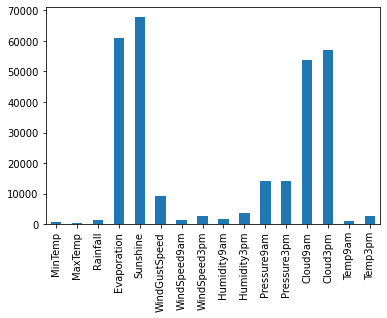

In [0]:
df[numerical].isnull().sum().plot.bar()
plt.show()

> As can be seen, **`Evaporation`**, **`Sunshine`**, **`Cloud9am`** and **`Cloud3pm`** are the ones with the highest number of missing values in numerical segment.

In [0]:
round(df[numerical].isnull().sum() / 142193, 3)

MinTemp          0.004
MaxTemp          0.002
Rainfall         0.010
Evaporation      0.428
Sunshine         0.477
WindGustSpeed    0.065
WindSpeed9am     0.009
WindSpeed3pm     0.018
Humidity9am      0.012
Humidity3pm      0.025
Pressure9am      0.099
Pressure3pm      0.098
Cloud9am         0.377
Cloud3pm         0.402
Temp9am          0.006
Temp3pm          0.019
dtype: float64

> Approximately 48% values of **`Sunshine`** is missing while the rate for **`Evaporation`**,**`Cloud9am`** and **`Cloud3pm`** is at around 40%.  

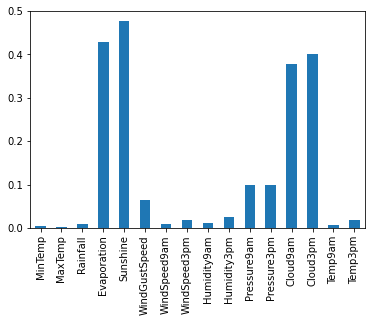

In [0]:
(df[numerical].isnull().sum() / 142193).plot.bar()
plt.show()

Similarly, we calculate and plot the number of missing values in categorical variables

In [0]:
df[categorical].isnull().sum()

Date                0
Location            0
WindGustDir      9330
WindDir9am      10013
WindDir3pm       3778
RainToday        1406
RainTomorrow        0
dtype: int64

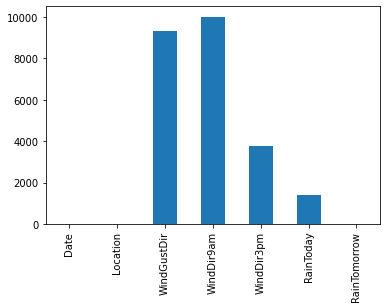

In [0]:
df[categorical].isnull().sum().plot.bar()
plt.show()

In [0]:
round(df[categorical].isnull().sum() / 142193, 3)

Date            0.000
Location        0.000
WindGustDir     0.066
WindDir9am      0.070
WindDir3pm      0.027
RainToday       0.010
RainTomorrow    0.000
dtype: float64

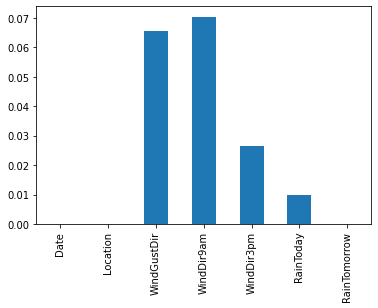

In [0]:
(df[categorical].isnull().sum() / 142193).plot.bar()
plt.show()

> The missing rate in categorical variable is not much since the highest one is around ***7%*** of **`WindDir9am`**. On the other hand, **`Date`**, **`Location`** and especially our target variable **`RainTomorrow`** show no sign of missing values

Let's inspect the **distribution** of **numerical variables**.

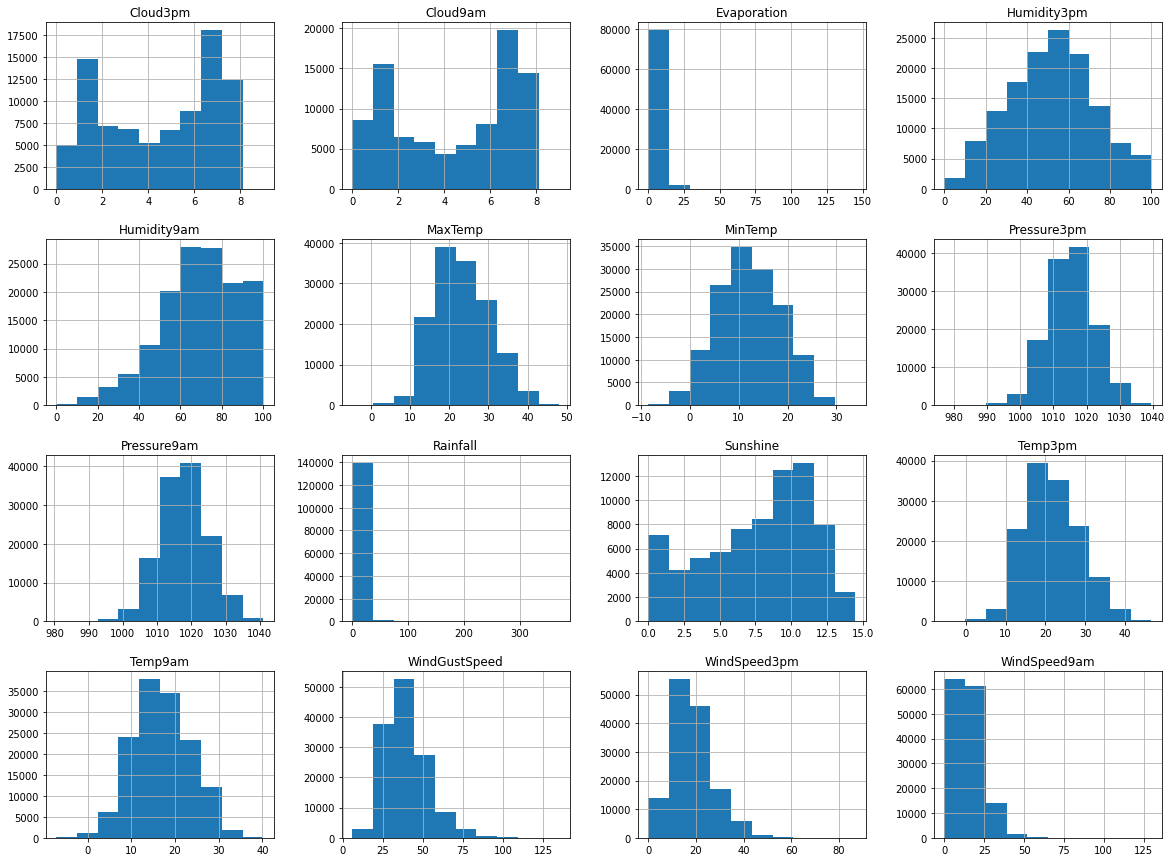

In [0]:
df[numerical].hist(bins=10, figsize = (20,15))
plt.show()

> The histograms show us that some variables follow normal distribution, for example **`Humidity3pm`**, **`MinTemp`**, **`Temp9am`** while some are highly skewed, namely **`Evaporation`**, **`Rainfall`**. We will process these values later before using them for the model.

Some descriptive statistics about categorical variables

In [0]:
df[categorical].describe()

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,142193,142193,132863,132180,138415,140787,142193
unique,3436,49,16,16,16,2,2
top,2013-12-17,Canberra,W,N,SE,No,No
freq,49,3418,9780,11393,10663,109332,110316


> From the summary table, we can see the most frequent values of each variable and its frequency in the dataset. 

Here, we have 2 binary-class variables **RainToday** and **RainTomorrow**. Let's see the values of these two variables.

In [0]:
print(df['RainToday'].value_counts())
print(df['RainTomorrow'].value_counts())

No     109332
Yes     31455
Name: RainToday, dtype: int64
No     110316
Yes     31877
Name: RainTomorrow, dtype: int64


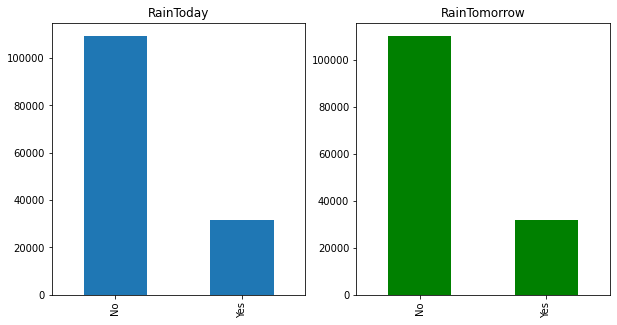

In [0]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
df['RainToday'].value_counts().plot.bar()
plt.title('RainToday')
plt.subplot(1,2,2)
df['RainTomorrow'].value_counts().plot.bar(color='g')
plt.title('RainTomorrow')
plt.show()

> As we can see, both of the graph show the same proportion between its values. In our target variable **RainTomorrow**, there is a big difference between the number of yes-no values. We have to take this into consideration when sampling to avoid biasness in the model.

Let's have a look at some statistics of the dataset

In [0]:
df[numerical].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


> The table shows that variables are of **different ranges**

Let's draw boxplots to inspect the **range** of the data and **anomalies**.

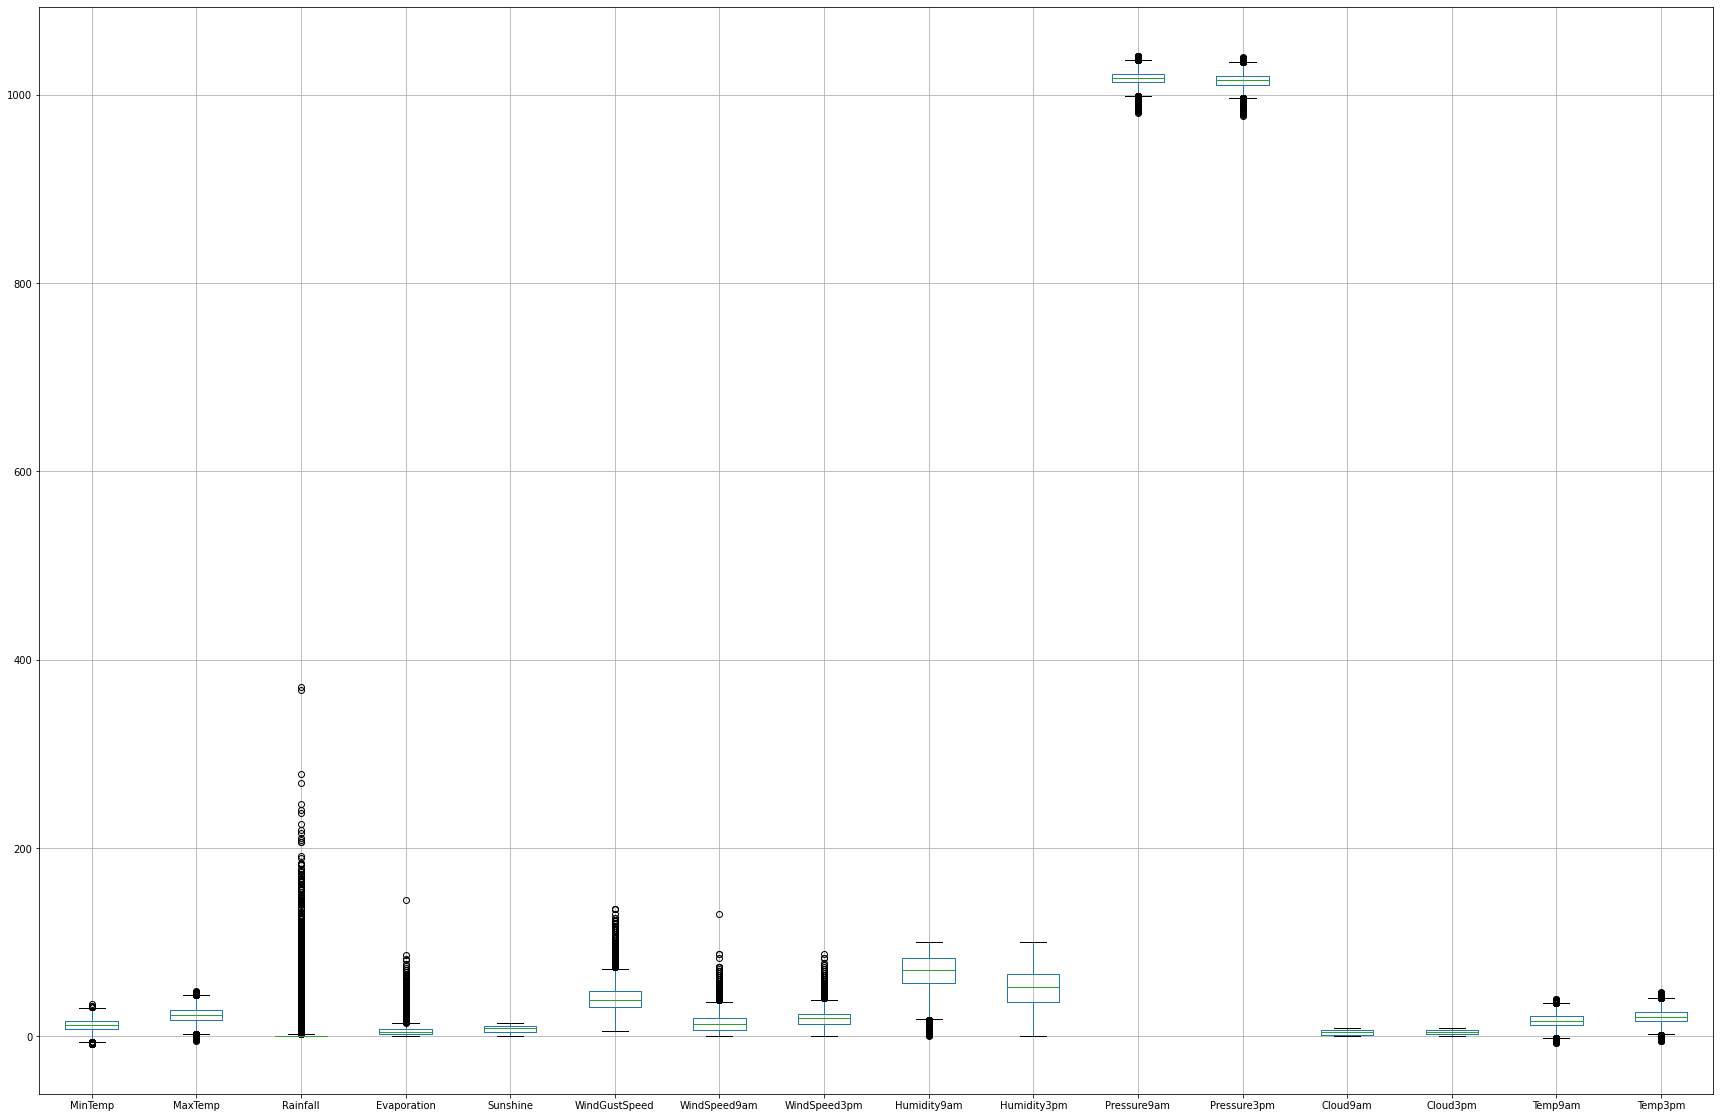

In [0]:
df[numerical].boxplot(figsize=(30,20))
plt.show()

> The boxplots reveal a great number of outliers in **`Rainfall`**, **`Evaporation`**, **`WindGustSpeed`**, **`WindSpeed9am`** and **`WindSpeed3pm`**

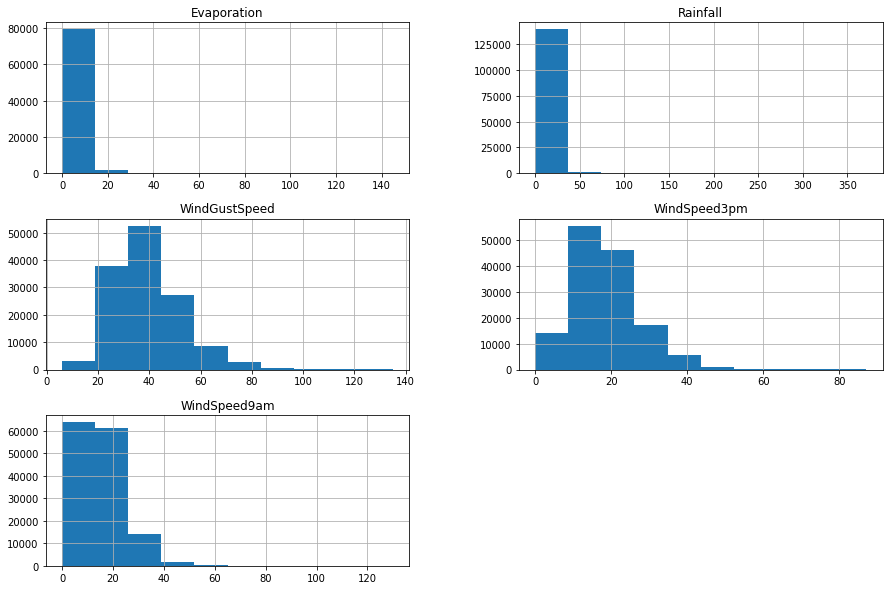

In [0]:
outlier = ['Rainfall', 'Evaporation', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']
df[outlier].hist(bins=10, figsize=(15,10))
plt.show()

> We can see that the distribution of those suspected variable is **skewed** and need to be taken care of

Let's draw a heatmap to see the correlation between variables

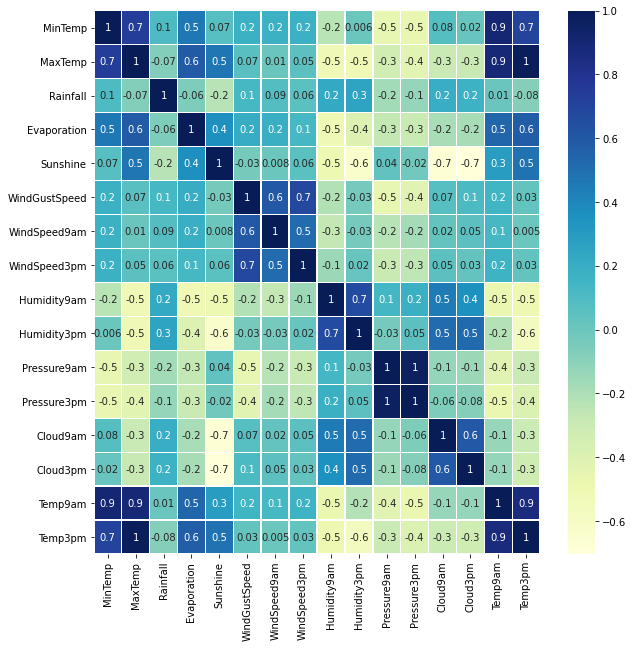

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
cm = sns.heatmap(df.corr(), linewidths = .5, cmap="YlGnBu", annot=True, ax=ax, fmt='.1g')

> From this heatmap, we can see blocks of **highly correlated** variables along the main diagonal.

Since we want to see if there is any correlation between the **date**, **month** or **season** and the target variable, we will create new variable in the dataset by extracting corresponding data from **`Date`** variable.

In [0]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [0]:
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Day,Month
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,1,12
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,2,12
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,3,12
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,4,12
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,5,12


In [0]:
df['Season'] = df['Month'].replace((1,2,3,4,5,6,7,8,9,10,11,12), ('Summer', 'Summer', 'Autumn', 'Autumn', 'Autumn', 'Winter', 'Winter', 'Winter', 'Spring', 'Spring', 'Spring', 'Summer'))
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Day,Month,Season
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,1,12,Summer
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,2,12,Summer
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,3,12,Summer
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,4,12,Summer
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,5,12,Summer


> Now the data already have the features that we want and the **`Date`** variable is of no use, we will get rid of this variable by **dropping** it.

In [0]:
df.drop('Date', axis = 1, inplace = True)
categorical = [i for i in df.columns if i not in numerical] #Update the list of categorical variables
categorical

['Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow',
 'Day',
 'Month',
 'Season']

We plot the correlation matrix again to see the new values.

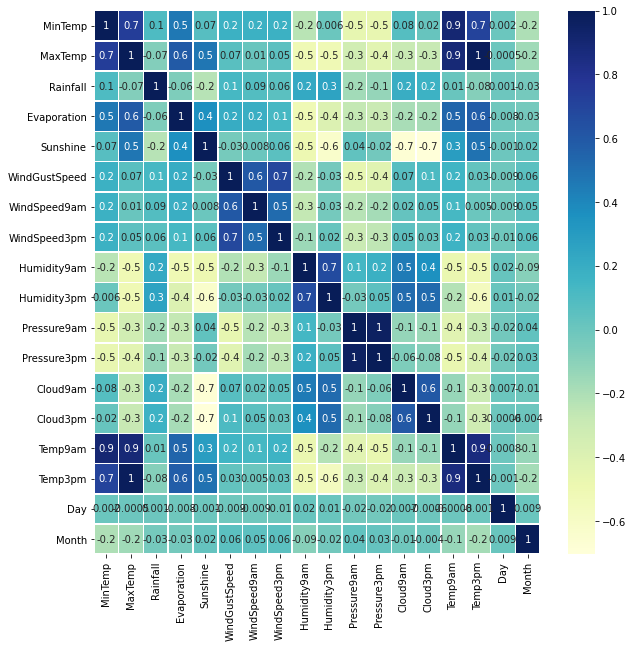

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
cm = sns.heatmap(df.corr(), linewidths = .5, cmap="YlGnBu", annot=True, ax=ax, fmt='.1g')

> As can be seen from the heatmap, there are strong correlations between variables of the same type, for example **`Pressure9am`** and **`Pressure3pm`**, **`Temp9am`** and **`Temp3pm`** and so on.

## **II. Data preparation**

In this part, we will prepare the data to better expose the underlying data patterns.

### ***1. Data cleaning***

In the data cleaning task, we will come to **remove outliers** and deal with **missing values**.

In this case, we will remove the outliers that initially detected in the boxplots. To determine whether a datapoint is outlier or not, we will calculate the **interquartile method**.

An interquartile will be calculated by the formula: **IQR = Q3 - Q1**

In [0]:
IQR_o = df[outlier].quantile(0.75) - df[outlier].quantile(0.25)
print(IQR_o)

Rainfall          0.8
Evaporation       4.8
WindGustSpeed    17.0
WindSpeed9am     12.0
WindSpeed3pm     11.0
dtype: float64


We then iterately compute the **upper bound** and **lower bound** of each variable.

In [0]:
# Let's find outliers values of Rainfall
upb_rf = round(df['Rainfall'].quantile(0.25) - 1.5*IQR_o[0], 3)
lob_rf = round(df['Rainfall'].quantile(0.75) + 1.5*IQR_o[0], 3)
print('Upper bound is:', upb_rf)
print('Lower bound is:', lob_rf)

Upper bound is: -1.2
Lower bound is: 2.0


In [0]:
# Let's find outliers values of Evaporation
upb_ev = round(df['Evaporation'].quantile(0.25) - 1.5*IQR_o[1], 3)
lob_ev = round(df['Evaporation'].quantile(0.75) + 1.5*IQR_o[1], 3)
print('Upper bound is:', upb_ev)
print('Lower bound is:', lob_ev)

Upper bound is: -4.6
Lower bound is: 14.6


In [0]:
# Let's find outliers values of WindGustSpeed
upb_wg = round(df['WindGustSpeed'].quantile(0.25) - 1.5*IQR_o[2], 3)
lob_wg = round(df['WindGustSpeed'].quantile(0.75) + 1.5*IQR_o[2], 3)
print('Upper bound is:', upb_wg)
print('Lower bound is:', lob_wg)

Upper bound is: 5.5
Lower bound is: 73.5


In [0]:
# Let's find outliers values of WindSpeed9am
upb_ws9 = round(df['WindSpeed9am'].quantile(0.25) - 1.5*IQR_o[3], 3)
lob_ws9 = round(df['WindSpeed9am'].quantile(0.75) + 1.5*IQR_o[3], 3)
print('Upper bound is:', upb_ws9)
print('Lower bound is:', lob_ws9)

Upper bound is: -11.0
Lower bound is: 37.0


In [0]:
# Let's find outliers values of WindSpeed3pm
upb_ws3 = round(df['WindSpeed3pm'].quantile(0.25) - 1.5*IQR_o[4], 3)
lob_ws3 = round(df['WindSpeed3pm'].quantile(0.75) + 1.5*IQR_o[4], 3)
print('Upper bound is:', upb_ws3)
print('Lower bound is:', lob_ws3)

Upper bound is: -3.5
Lower bound is: 40.5


Let's look at the statistics of these variable again.

In [0]:
df[outlier].describe()

,Rainfall,Evaporation,WindGustSpeed,WindSpeed9am,WindSpeed3pm
count,140787.000000,81350.000000,132923.000000,140845.000000,139563.000000
mean,2.349974,5.469824,39.984292,14.001988,18.637576
std,8.465173,4.188537,13.588801,8.893337,8.803345
min,0.000000,0.000000,6.000000,0.000000,0.000000
25%,0.000000,2.600000,31.000000,7.000000,13.000000
50%,0.000000,4.800000,39.000000,13.000000,19.000000
75%,0.800000,7.400000,48.000000,19.000000,24.000000
max,371.000000,145.000000,135.000000,130.000000,87.000000


> As we can see:
1.   The minimum of **Rainfall** is 0 and maximum is 371, therefore, the outliers will be values that ***> 2***
2.   Similarly, the outliers values in **Evaporation** will be ***> 14.6***
3. The outliers in **WindGustSpeed** will be values that are ***> 73.5***
4. For **WindSpeed9am**, the outlier values will be ***> 37***
5. And the outliers in **WindSpeed3pm** will be ***> 40.5***





Let's come back to our dataset and get rid of these values

In [0]:
df = df[~((df ['Rainfall'] > 2) |(df['Evaporation'] > 14.6) | (df['WindGustSpeed'] > 73.5) | (df['WindSpeed9am'] > 37) | (df['WindSpeed3pm'] > 40.5))]
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Day,Month
count,111073.000000,111348.000000,110286.000000,63362.000000,57887.000000,104481.000000,110487.000000,109553.000000,110264.000000,108841.000000,100332.000000,100357.000000,67958.000000,65252.000000,110917.000000,109517.000000,111613.000000,111613.000000
mean,11.841628,23.727452,0.155144,5.333263,8.145458,37.741321,12.996398,17.722846,66.648743,48.480931,1018.604690,1015.943159,4.055902,4.168746,17.060192,22.214529,15.683558,6.380529
std,6.445615,6.959156,0.392059,3.137946,3.613732,11.369613,7.971028,7.878758,18.503045,19.611390,6.688906,6.711231,2.885687,2.733836,6.497249,6.766378,8.791105,3.422233
min,-8.500000,-4.100000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,0.000000,984.600000,980.200000,0.000000,0.000000,-5.600000,-4.400000,1.000000,1.000000
25%,7.200000,18.600000,0.000000,2.800000,5.800000,30.000000,7.000000,11.000000,55.000000,34.000000,1014.000000,1011.300000,1.000000,1.000000,12.400000,17.300000,8.000000,3.000000
50%,11.700000,23.300000,0.000000,5.000000,9.100000,37.000000,13.000000,17.000000,67.000000,49.000000,1018.400000,1015.800000,4.000000,4.000000,16.900000,21.700000,16.000000,6.000000
75%,16.500000,28.700000,0.000000,7.400000,10.900000,44.000000,19.000000,22.000000,79.000000,62.000000,1023.100000,1020.500000,7.000000,7.000000,21.700000,26.900000,23.000000,9.000000
max,33.900000,47.300000,2.000000,14.600000,14.500000,72.000000,37.000000,39.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,31.000000,12.000000


In [0]:
df[outlier].describe()

,Rainfall,Evaporation,WindGustSpeed,WindSpeed9am,WindSpeed3pm
count,110286.000000,63362.000000,104481.000000,110487.000000,109553.000000
mean,0.155144,5.333263,37.741321,12.996398,17.722846
std,0.392059,3.137946,11.369613,7.971028,7.878758
min,0.000000,0.000000,6.000000,0.000000,0.000000
25%,0.000000,2.800000,30.000000,7.000000,11.000000
50%,0.000000,5.000000,37.000000,13.000000,17.000000
75%,0.000000,7.400000,44.000000,19.000000,22.000000
max,2.000000,14.600000,72.000000,37.000000,39.000000


> Now that the statitics have changed, let's see if we finally get rid of the outliers.

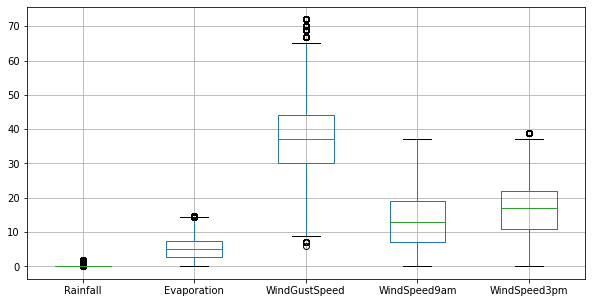

In [0]:
df[outlier].boxplot(figsize = (10,5))
plt.show()

> We can still spot some outliers here, but not many. Why? 
Because after removing outliers, the statistics values of the dataset will change. In this case we are using **interquartile (IQR)**, which means we are using **median** values. The median values will change a little and not much affected by the removed outliers. That's why the new **range**, in other words, **upper bound** and **lower bound** will slightly change.

Now that we get rid of outliers, let's handle missing values. Let's have a look again at the number of missing values!
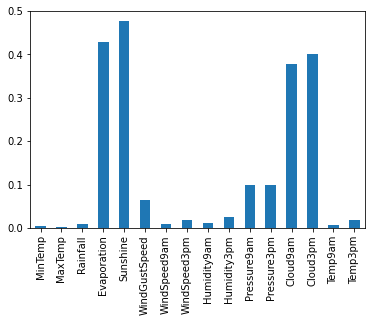 
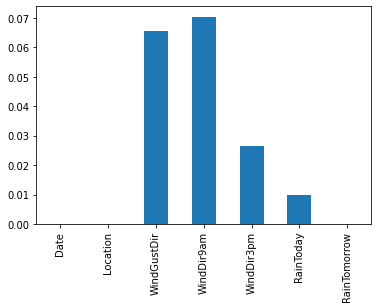

> As you can see, we have missing values in both numerical and categorical values so first we will handle categorical attributes and then numerical. After that, we will create a pipeline for feature engineering.

To fill missing values in numerical variables, we will make use of the **`SimpleImputer`** function in Scikit learn library. We will replace missing values with the median value of that feature.

In [0]:
from sklearn.impute import SimpleImputer
imputer_num = SimpleImputer(strategy="median")
imputer_num.fit(df[numerical])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [0]:
df[numerical] = imputer_num.transform(df[numerical])

Similarly, we use the **most frequent** value to fill in the place of missing values in categorical variables.

In [0]:
imputer_cat = SimpleImputer(strategy="most_frequent")
imputer_cat.fit(df[categorical])
df[categorical] = imputer_cat.transform(df[categorical])

In [0]:
df.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
Day              0
Month            0
Season           0
dtype: int64

> Now that there is no missing values in our dataset, let's move on to **feature selection** task

### ***2. Feature selection***
In this part, we will deal with highly correlated variables

Let's have a look at the correlation matrix again:

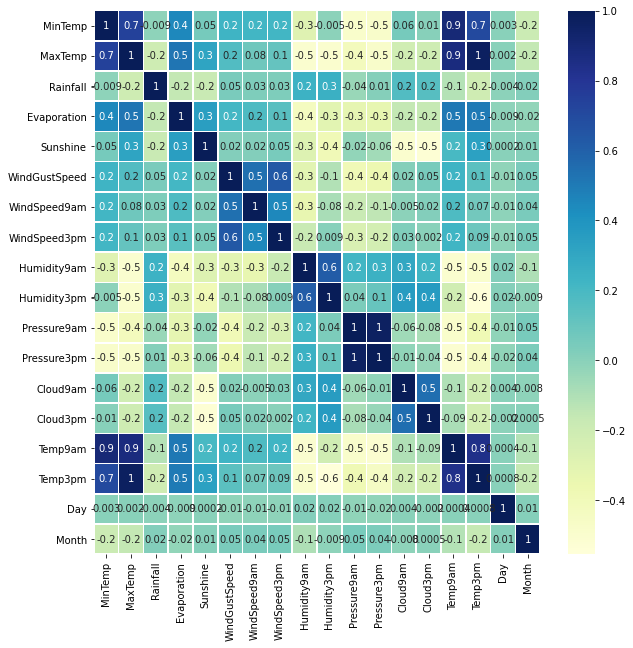

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
cm = sns.heatmap(df.corr(), linewidths = .5, cmap="YlGnBu", annot=True, ax=ax, fmt='.1g')

> As you can see, there's a perfect correlation between **`Pressure9am`** and **`Pressure3pm`**, which mean the two variables represent the same information. Therefore, I will get rid of either of them, in this case, **`Pressure3pm`**

In [0]:
df.drop(labels='Pressure3pm', axis = 1, inplace= True)
df.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
       'RainToday', 'RainTomorrow', 'Day', 'Month', 'Season'],
      dtype='object')

> The feature **`Pressure3pm`** has already gone!

### ***3. Feature engineering***
Since Machine learning algorithms require input and target variables to be **numerical** so in this part, we will transform our **categorical** values into **numeric** ones. 

We will make use of the **`LabelEncode`** function from scikit-learn. This function basically assigns values between 0 and number of classes - 1.

> For example, **[A, B, C]** will be decoded as **[0, 1, 2]**.

In [0]:
from sklearn.preprocessing import LabelEncoder
lb_encoder = LabelEncoder()

After calling the function, we will fit and transform the target labels.

In [0]:
for i in df[categorical].columns:
  df[i] = lb_encoder.fit_transform(df[i])

Let's see the result after transformation

In [0]:
for i in df[categorical]:
  print(i, ':', df[i].unique())

Location : [ 2  4 10 11 21 24 26 27 30 34 37 38 42 45 47  9 40 23  5  6 35 19 18 20
 25 33 44 12  7  8 14 39  0 22 28 48  1 46 29 32 31 36 43 15 17  3 13 16
 41]
WindGustDir : [13 14 15  4  3  1 10  8 12  6  7  9  5  2  0 11]
WindDir9am : [13  6  9  1 12 10  8  3 11  4  2  0  7 15 14  5]
WindDir3pm : [14 15  0  7 13 10  2  6  9  3 12 11  8  5  4  1]
RainToday : [0 1]
RainTomorrow : [0 1]
Day : [ 0  1  2  3  4  5  6  7  9 10 15 16 19 20 21 22 23 24 25 26 27 28 29 30
  8 11 12 13 14 17 18]
Month : [11  0  1  2  3  4  5  6  7  8  9 10]
Season : [2 0 3 1]


In [0]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Day,Month,Season
0,2,13.4,22.9,0.6,5.0,9.1,13,44.0,13,14,20.0,24.0,71.0,22.0,1007.7,8.0,4.0,16.9,21.8,0,0,0,11,2
1,2,7.4,25.1,0.0,5.0,9.1,14,44.0,6,15,4.0,22.0,44.0,25.0,1010.6,4.0,4.0,17.2,24.3,0,0,1,11,2
2,2,12.9,25.7,0.0,5.0,9.1,15,46.0,13,15,19.0,26.0,38.0,30.0,1007.6,4.0,2.0,21.0,23.2,0,0,2,11,2
3,2,9.2,28.0,0.0,5.0,9.1,4,24.0,9,0,11.0,9.0,45.0,16.0,1017.6,4.0,4.0,18.1,26.5,0,0,3,11,2
4,2,17.5,32.3,1.0,5.0,9.1,13,41.0,1,7,7.0,20.0,82.0,33.0,1010.8,7.0,8.0,17.8,29.7,0,0,4,11,2


> We can see that our dataset now is purely numerical as required to apply ML algorithms.

### ***4. Feature scaling***
Since the the entries in our dataset are of different scales, we will scale them to a certain range.

Because we only scales the input features, therefor, we create a new variable to store only input features

In [0]:
input_variables = [i for i in df.columns if i != 'RainTomorrow']

In this project, we will use **`StandardScaler`**, which redistributes the features with their mean μ = 0 and standard deviation σ =1.

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[input_variables] = scaler.fit_transform(df[input_variables])
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Day,Month,Season
0,-1.524924,0.242467,-0.118897,1.145143,-0.079826,0.187113,1.243853,0.573183,1.410552,1.424853,0.883097,0.805825,0.236368,-1.368030,-1.716140,1.761197,-0.047158,-0.024578,-0.060402,-0.236604,0,-1.670282,1.642055,0.472262
1,-1.524924,-0.690662,0.197610,-0.392992,-0.079826,0.187113,1.449277,0.573183,-0.152276,1.644701,-1.134383,0.549621,-1.231754,-1.213122,-1.258881,-0.015115,-0.047158,0.021740,0.312572,-0.236604,0,-1.556530,1.642055,0.472262
2,-1.524924,0.164706,0.283930,-0.392992,-0.079826,0.187113,1.654701,0.754972,1.410552,1.644701,0.757005,1.062029,-1.558003,-0.954943,-1.731908,-0.015115,-1.003203,0.608436,0.148464,-0.236604,0,-1.442778,1.642055,0.472262
3,-1.524924,-0.410723,0.614822,-0.392992,-0.079826,0.187113,-0.604964,-1.244701,0.517507,-1.653011,-0.251735,-1.115705,-1.177379,-1.677845,-0.155153,-0.015115,-0.047158,0.160694,0.640790,-0.236604,0,-1.329026,1.642055,0.472262
4,-1.524924,0.880105,1.233448,2.170567,-0.079826,0.187113,1.243853,0.300501,-1.268581,-0.114079,-0.756106,0.293417,0.834492,-0.800036,-1.227346,1.317119,1.864930,0.114376,1.118196,-0.236604,0,-1.215275,1.642055,0.472262


In [0]:
df.describe()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Day,Month,Season
count,1.116130e+05,1.116130e+05,1.116130e+05,1.116130e+05,1.116130e+05,1.116130e+05,1.116130e+05,1.116130e+05,1.116130e+05,1.116130e+05,1.116130e+05,1.116130e+05,1.116130e+05,1.116130e+05,1.116130e+05,1.116130e+05,1.116130e+05,1.116130e+05,1.116130e+05,1.116130e+05,111613.000000,1.116130e+05,1.116130e+05,1.116130e+05
mean,-2.762395e-15,6.723627e-17,-5.001017e-16,1.426212e-14,2.556510e-14,5.263292e-15,-1.097896e-14,-1.511902e-14,7.096718e-14,4.500648e-15,-1.400854e-14,4.164668e-15,4.381929e-15,3.342218e-19,3.947551e-14,-1.176589e-14,-4.003887e-14,1.305754e-15,-2.320961e-16,6.102332e-15,0.160734,-1.675824e-16,-5.431499e-16,-2.509842e-15
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.367287,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.665706e+00,-3.163453e+00,-4.003291e+00,-3.929919e-01,-2.189497e+00,-3.252288e+00,-1.426661e+00,-2.880796e+00,-1.491843e+00,-1.653011e+00,-1.638754e+00,-2.268622e+00,-3.569874e+00,-2.504018e+00,-5.358444e+00,-1.791427e+00,-1.959247e+00,-3.498440e+00,-3.969171e+00,-2.366037e-01,0.000000,-1.670282e+00,-1.572234e+00,-1.292699e+00
25%,-8.914017e-01,-7.217660e-01,-7.375224e-01,-3.929919e-01,-3.329867e-01,1.493169e-01,-1.015813e+00,-6.993355e-01,-8.220593e-01,-7.736212e-01,-7.561057e-01,-8.595007e-01,-6.336299e-01,-6.967644e-01,-6.281795e-01,-4.591932e-01,-5.251805e-01,-7.193507e-01,-7.317555e-01,-2.366037e-01,0.000000,-8.740190e-01,-9.878182e-01,-1.292699e+00
50%,2.368556e-02,-2.191956e-02,-6.134997e-02,-3.929919e-01,-7.982623e-02,1.871125e-01,1.130805e-02,-6.307615e-02,-1.522759e-01,1.057686e-01,4.496325e-04,-9.088899e-02,1.886871e-02,2.613689e-02,-2.901258e-02,-1.511520e-02,-4.715849e-02,-2.457841e-02,-7.532092e-02,-2.366037e-01,0.000000,3.599582e-02,-1.111937e-01,-4.102186e-01
75%,8.683815e-01,7.245833e-01,7.155290e-01,-3.929919e-01,8.894741e-02,2.627038e-01,8.330046e-01,5.731832e-01,7.407685e-01,7.653109e-01,7.570049e-01,5.496207e-01,6.713673e-01,6.457666e-01,6.174569e-01,8.730408e-01,4.308635e-01,7.010726e-01,6.855464e-01,-2.366037e-01,0.000000,8.322588e-01,7.654307e-01,4.722617e-01
max,1.713078e+00,3.430656e+00,3.391445e+00,4.734126e+00,3.970741e+00,2.228075e+00,1.654701e+00,3.118221e+00,1.857074e+00,1.644701e+00,3.026671e+00,2.727354e+00,1.813240e+00,2.659563e+00,3.534454e+00,2.205275e+00,2.342952e+00,3.572798e+00,3.654421e+00,4.226477e+00,1.000000,1.742274e+00,1.642055e+00,1.354742e+00


> The range and statistics of the dataset has changed, which mean features have been scaled.

## **III. Train models**
In this part, we will train our model using different ML algorithms. 

Since this is a **classification task**, we will use 2 algorthms in this project, namely:


1.   **Logistic Regression**
2.   **XGBoost Classifier**



First, let's call **`x`** our input data and **`y`** our target variable, we then ***split*** our dataset into **train set** and **test set**.

In [0]:
x = df[input_variables]
y = df['RainTomorrow']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size=0.2, random_state=5)

> Here, we keep **20%** of the dataset for testing by assigning **`test_size=0.2`**, the **`random_state`** is set to 5 to guarantee that each time we run the code, the same sequences of random number are generated. 

> Remember that when we inspect the target variable **`RainTomorrow`**, there is a big gap between the number of observations of 2 classes. Therefore, the dataset will be split using **stratified sampling** method by setting the parameter **`stratify = y`** to ensure the data is representative.

### ***1. Logistic Regression***
Logistic regression is a ML model that is mainly used for classification problems. The model will calculate the probability of the datapoints belong to each class and then make the final decision by taking the highest probability.

Let's create a Logistic Regression model:

In [0]:
from sklearn.linear_model import LogisticRegression
lg_model = LogisticRegression(penalty = 'l2', random_state = 5)
lg_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

> The logistic regression is created using **`l2 regularization`** and **`random_state=5`**

In [0]:
from sklearn.metrics import accuracy_score
y_pred_lg = lg_model.predict(X_test)
print(accuracy_score(y_test, y_pred_lg))

0.8661022264032612


> Here, we will use the **`accuracy`** score to see how accurately the model can predict on the **test set** when trained on the **train set**. 

> As displayed, the **logistic regression model** can predict whether it rains tomorrow or not with the accuracy of ***86.6%***

Let's check with the result on train set to see if it is overfitting.

In [0]:
print("Test score:", lg_model.score(X_test, y_test))
print("Train score:", lg_model.score(X_train, y_train))

Test score: 0.8661022264032612
Train score: 0.8657968417515959


> The scores on both training set and test set are **roughly the same**, which mean that this model **generalises well** with ***unseen data***.

Let's plot a **confusion matrix** to see how many cases were predicted correctly/ incorrectly.

In [0]:
from sklearn.metrics import confusion_matrix
cfm_lg = confusion_matrix(y_test, y_pred_lg)

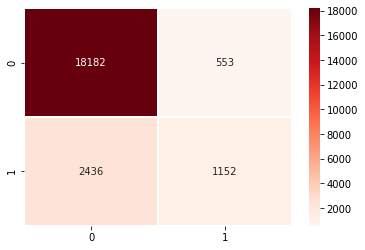

In [0]:
sns.heatmap(cfm_lg, annot=True, fmt="d", linewidths=.5, cmap = 'Reds')
plt.show()

> The heatmap shows us that:  
* **18182** of them were ***correctly*** classified as ***No***.
* **553** were ***wrongly*** classified as ***Yes***.
* **2436** were ***wrongly*** classified as ***No***
* **1152** were ***correctly*** classified as ***Yes***.

> ***! Warning***: Each time we run this notebook, the number will be different with the number mentioned above.


Let's calculate the **precision** and **recall** score for this model. In this case, the "**No**" will be **negative** class while "**Yes**" will be our **positive** class.

We will use the **`classification_report`** from **`sklearn.metrics`** library



In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lg))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92     18735
           1       0.68      0.32      0.44      3588

    accuracy                           0.87     22323
   macro avg       0.78      0.65      0.68     22323
weighted avg       0.85      0.87      0.85     22323



> We can see that the this model is better at predicting if there is no rain tomorrow since the scores for ***class 0*** are much **higher** than ***class 1***.

> Base on the situation we should ask for a high precision or recall score. 

> **For example**, given the bushfire recently happened in Australia, if it rains tomorrow in this area, we can plan to focus the fire fighter teams on the other spot, which means we want to minimize the case that wrongly predict it rains tomorrow in this area. In other words, we want to ***minimize the FP***, which leads to higher **precision score**.

### ***2. XGBoost Classifier***
In this part, we will initialize an XGBClassifier and train the model. This classifies using eXtreme Gradient Boosting - using gradient boosting algorithms for modern data science problems. It falls under the category of **Ensemble Learning** in ML, where we train and predict using many models to produce one superior output.
XGBoost is a popular and efficient open-source implementation of the **gradient boosted trees** algorithm. Gradient boosting is a supervised learning algorithm, which attempts to accurately predict a target variable by combining the estimates of a set of simpler, weaker models.

In [0]:
from xgboost import XGBClassifier
XGB_model = XGBClassifier()
XGB_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

> Here, we will take the default value for all the parameters. The number of trees this model will create will be 100 as **`n_estimators=100`**.
If **`n_estimator=1`**, this model will create only **1 tree** and basically work as a **DecisionTree Classifier** algorithm.

Let's see how well this model can perform!

In [0]:
y_pred = XGB_model.predict(X_test)
print(accuracy_score(y_test, y_pred)*100)

87.25529722707522


> Its accuracy is **~87.25%**, which is a relatively high score. However, is this the best? Let's use **`GridCVSearch`** to iterate through the list of number of estimators and find out the best one!

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
n_estimators = range(100, 500, 50)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)
grid_search = GridSearchCV(XGB_model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

> We are doing a **grid search** on a list of estimators ranging from **100 to 500** with **step = 50**. In this case, we created **80 models** since we have **8 estimators** (100, 150, 200, 250, 300, 350, 400, 450) and **10 folds** cross validation. The scoring is set to **`roc_auc`** to compute the area under the ROC curve (ROC AUC) from prediction scores.
**`n_jobs=-1`** means that we will use all the processors to boost the running time.
> It took about **10 mins** to run this grid search on this kernel.

In [0]:
print('Best score:', grid_result.best_score_)
print('Best parameter:', grid_result.best_params_)
print('Best estimator:', grid_result.best_estimator_)

Best score: 0.8651028692460379
Best parameter: {'n_estimators': 450}
Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=450, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


> We can see that the best score is **0.86** when the **n_estimators** is **450** and other paramaters settings. We will use all these parameters to run our model!

In [0]:
best_model = grid_result.best_estimator_
best_model.score(X_test, y_test)

0.8761815168212158

> We can see that the model return an accuracy score of **87.6%**, higher than the defaul settings.
However, the best score from the grid search is **different** from the one we run using the best parameters, why this happened? 

>This can be explained by the fact that we are running our model on the test set whereas in the grid search, we evaluate the model using cross validation. Since we have **10 folds** cross validation, the score is the **average** of the **10 models**, therefore, the score cannot be expected to be the same.

Let's calculate the score on training set to see if the model is overfitting or not!

In [0]:
print("Test score:", best_model.score(X_test, y_test))
print('Train score:', best_model.score(X_train, y_train))

Test score: 0.8761815168212158
Train score: 0.8806585283906373


> The train score is higher than the test score but the gap is not significant so we can conclude that it's **slightly overfitting** here.

Since **xgboost** is a decision tree based ensemble ML algorithm, the model consists of a set of **classification and regression trees** (CART). Let's visualise a single decision tree within this trained
model to get insight into the **gradient boosting** process.

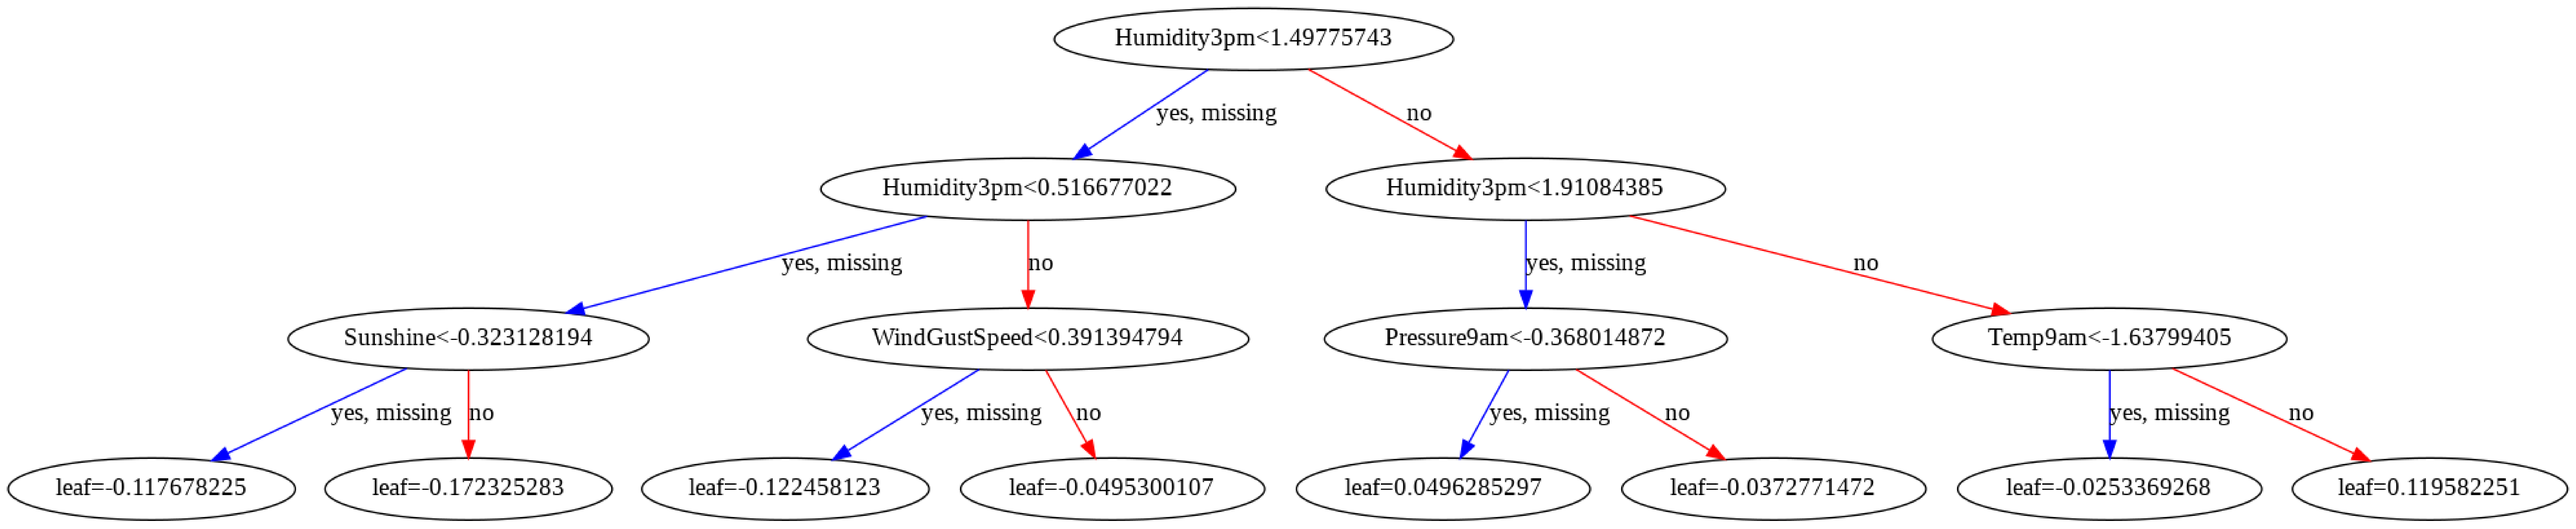

In [0]:
from xgboost import plot_tree
fig, ax = plt.subplots(figsize=(200, 200))
plot_tree(best_model, num_trees=0, ax=ax)
plt.show()

> We can see the features and feature values for each split and also the score of the leaf nodes. If the feature values meet the condition or the value is missing, it will come to the right node and left node otherwise. This is the reason why XGBoost can handle missing values in the dataset to minimize the loss.
> The value in the **leaf node** is the predicted **probability** of the datapoint belong to **class 1** since our target variable is a binary class.

> We can also visualise another decision tree by modifying the parameter **num_trees** with the tree index that we want to visualise. For example, we will visualise the fifth decision tree with the parameter **`num_trees = 4`**

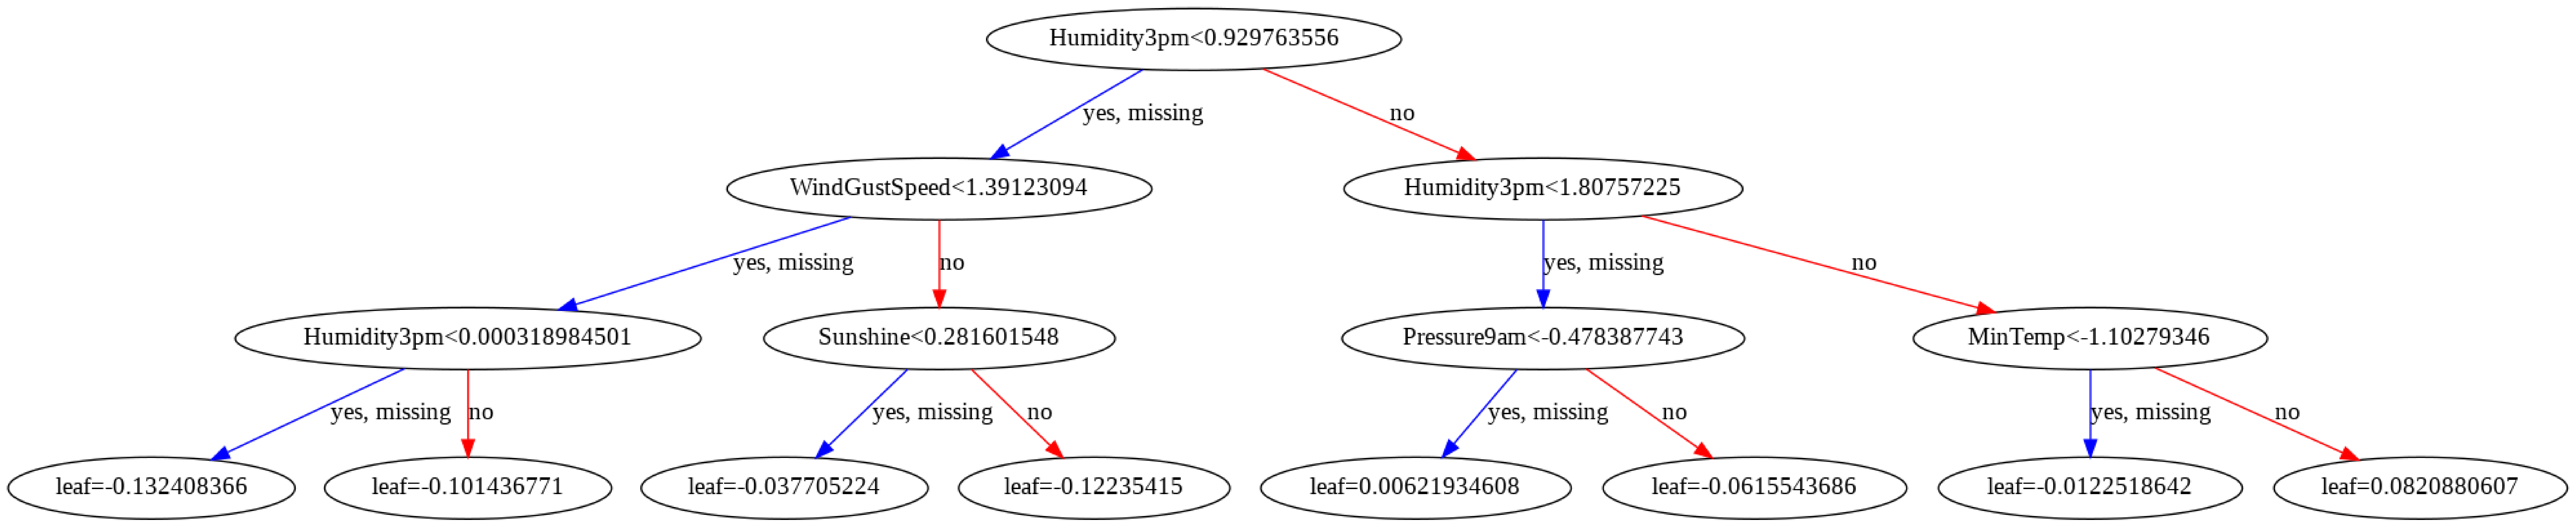

In [0]:
fig, ax = plt.subplots(figsize=(200, 200))
plot_tree(best_model, num_trees=4, ax=ax)
plt.show()

> Since our best model uses the **`n_estimator = 450`**, thus, there will be **450 trees** in our XGB model.

Let's have a look at the AUC ROC of this model

In [0]:
y_pred_xgb = best_model.predict_proba(X_test)[:, 1].reshape(-1,1)

> Here we are calculating the probability of the datapoints falling into each class. We just care about the probability it rains tomorrow so we just only extract that data.

Let's plot the ROC curve

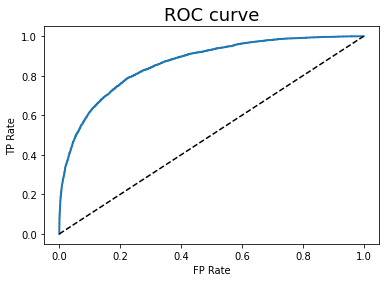

In [0]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 15
plt.title('ROC curve')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.show()

> From this ROC curve, we can choose a thresold that help us balance the **sensitivity** (TP rate) and **specificity** (TN rate) rate based on our own preference.

Let's see the area under the ROC curve

In [0]:
from sklearn.metrics import roc_auc_score
ROC_AUC = roc_auc_score(y_test, y_pred_xgb)
print('Area under the ROC curve:', ROC_AUC)

Area under the ROC curve: 0.8635812105648843


> The AUC ROC value shows us that the performance of the model is good to predict if it rains tomorrow.

## **IV. Conclusion**
In this project, we have used 2 different ML algorithms to predict whether it rains tomorrow or not and the performance is as followed:
* **Logistic Regression**: approx. ***86.6%***
* **XGBoost Classifier**: approx. ***87.6%***

Overall, the two models seem to perform well on this dataset with no sign of overfitting.

# ***Thanks for your attention***

---



---

